SEEDS
=====
Introduzione
------------
Il problema posto dal caso di studio che andiamo a considerare è quello di una classificazione di 3 tipi di grano (Kama, Rosa e Canadian) secondo delle misurazioni fatte sulle proprietà geometriche e strutturali dei chicchi tramite tecniche di "soft X-rays". Si tratta di un problema prettamente di classificazione, ma anche tecniche di clustering possono dare informazioni ed essere utili alle fasi successive.

Per aiutarci nell'analisi del dataset e nello sviluppo del modello GMM, si è scelto Python come linguaggio di programmazione data la sua versatilità e la quantità (e qualità) di librerie dedicate all'algebra, allo studio di dataset tramite machine learning e alla visualizzazione dei dati.

Il dataset
----------
Il dataset "Seeds" contiene un totale di $N=210$ elementi di dimensione $M=7$ ognuno, più la label del tipo di grano identificato dal vettore. Abbiamo quindi $\boldsymbol{X}\in\mathbb{R}^{210\text{x}7}$. Visto che stiamo applicando tecniche di clustering, metodo non supervisionato, non ci interessa la label, se non per le considerazioni finali, ma vogliamo ottenere delle strutture che saranno di supporto nell'analisi del dataset.

I sample hanno i seguenti attributi:

1. Area $A$

2. Perimetro $P$

3. Compattezza, calcolata come $C = \frac{4\pi A}{P^2}$

4. Lunghezza del chicco

5. Larghezza del chicco

6. Coefficiente di asimmetria

7. Lunghezza dell'incavo del chicco

ognuno dei quali è un numero appartenente ai reali, come già specificato sopra.

Visualizzazione del dataset
---------------------------
Visto che il dataset è composto da elementi in $\mathbb{R}^7$ non possiamo visualizzarlo direttamente, ma dobbiamo prima applicare allo stesso _tecniche di visualizzazione_. Vogliamo visualizzare i dati in uno spazio $\mathbb{R}^2$ e, per farlo, sono state scelte la tecniche più tipiche: il _MultiDimensional Scaling_ (MDS), che assicura che punti vicini nello spazio originario siano vicini anche nello spazio di dimensione ridotta, e il _Principal Component Analysis_ (PCA), che proietta i dati in nuove direzioni, ordinate secondo la loro varianza spiegata, e da cui noi preleviamo tante direzioni quante dimensioni vogliamo.

In [1]:
import numpy as np
from scipy import linalg

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as pltcolors

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

D = np.genfromtxt('seeds_dataset.tsv', delimiter='\t')
X = np.delete(D,7,1) #rimozione della label
print('N =', X.shape[0], ', M =', X.shape[1])

N = 210 , M = 7


Innanzitutto un po' di _preprocessing_ sui dati. Normalizziamoli per ottenere migliori risultati nelle fasi successive e avere informazioni sulla media e la varianza dei dati di partenza

In [2]:
seed = 42
np.random.seed(seed) #per la riproduzione dei risultati
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
print('Mean:', scaler.mean_, '\nVariance:',scaler.var_)
with np.printoptions(suppress=True): #solo per visualizzare 0 invece di numeri infinitesimi
    print('Normalised mean:',X_norm.mean(axis=0),'\nNormalised variance:',X_norm.var(axis=0))

Mean: [14.84752381 14.55928571  0.87099857  5.62853333  3.25860476  3.70020095
  5.40807143] 
Variance: [8.42603482e+00 1.69740663e+00 5.55690522e-04 1.95370458e-01
 1.41988830e-01 2.24991888e+00 2.40402828e-01]
Normalised mean: [-0. -0.  0. -0. -0.  0. -0.] 
Normalised variance: [1. 1. 1. 1. 1. 1. 1.]


Per quanto riguarda MDS, non usiamo i dati normalizzati, dato che ci servono le distanze vere tra gli stessi per ottenere una corretta rappresentazione in uno spazio di minori dimensioni. I dati verranno solo centrati dalla procedura stessa

In [3]:
embedding = MDS(n_components=2, random_state=seed)
X_transformed = embedding.fit_transform(X)
print('N =', X_transformed.shape[0], ', M =', X_transformed.shape[1])

N = 210 , M = 2


Come vediamo il dataset è stato ridotto a vettori bidimensionali.

Il valore di stress finale dell'MDS, ossia la somma degli errori quadratici tra la distanza effettiva dei punti nello spazio di partenza e i punti ottenuti dalla trasformazione nello spazio ridotto, ottenuto come

$stress(\boldsymbol{x}_1,\boldsymbol{x}_2,\cdots,\boldsymbol{x}_N) = \sqrt{\sum_{i \neq j=1,2,\cdots,N}(d_{ij} - ||\boldsymbol{x}_i - \boldsymbol{x}_j||)^2}$

è pari a

In [4]:
print('Stress:',embedding.stress_)

Stress: 53.10153547772634


Visualizzando

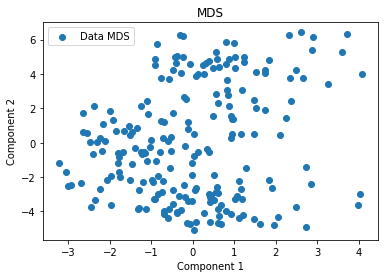

In [5]:
fig = plt.scatter(X_transformed[:,0],X_transformed[:,1], label='Data MDS')
plt.legend(loc='best')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('MDS')
plt.show()

sembrano effettivamente esserci alcune agglomerazioni di dati. A priori non sappiamo quanti cluster ci siano effettivamente, quindi dovremo provare diversi valori per $K$ nell'implementazione di un GMM.

Altro modo per visualizzare i dati in uno spazio ridotto è sfruttare PCA. Sfrutteremo, in questo caso, i dati normalizzati. Per la visualizzazione preleveremo le prime due componenti ottenute dal PCA e vediamo che la percentuale di varianza spiegata delle stesse è

In [6]:
pca = PCA(n_components=2, random_state=seed)
X_transformedPCA = pca.fit_transform(X_norm)
print('Explained variance ratio for\nComponent 1:',
      pca.explained_variance_ratio_[0],
      '\nComponent 2:',
      pca.explained_variance_ratio_[1])
print('Total explained variance:',np.sum(pca.explained_variance_ratio_))

Explained variance ratio for
Component 1: 0.7187430265675441 
Component 2: 0.1710818352815798
Total explained variance: 0.8898248618491239


circa $0.89\%$. Riteniamo quindi una buona percentuale della varianza totale del dataset, anche se una componente in più non farebbe male. Per semplicità ci limitiamo a visualizzare i dati in uno spazio 2D.

Queste _riduzioni di dimensionalità_ dei dati potrebbero tornare utili come fase di _preprocessing_ per l'eventuale successiva classificazione, se fosse quello lo scopo dell'analisi, per semplificare i dati stessi in input al metodo di classificazione scelto e velocizzare quindi la fase di _training_.

Visualizzando i dati ottenuti tramite PCA

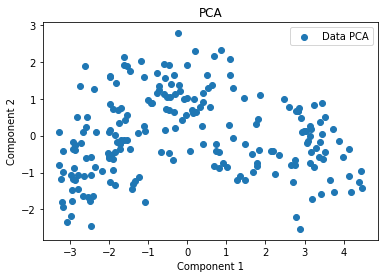

In [7]:
fig = plt.scatter(X_transformedPCA[:,0],X_transformedPCA[:,1], label='Data PCA')
plt.legend(loc='best')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA')
plt.show()

possiamo anche qui notare diverse agglomerazioni di dati il che, ancora una volta, giustificano l'applicazione di un metodo di clustering.

Dopo questa prima analisi visiva, soprattutto aiutata da PCA, e basandoci sulle sezioni dello spazio 2D in cui più dati sono agglomerati, sembrerebbe che i cluster siano 2, 3 o 4. Teniamo questi numeri per $K$ per evitare di fare _overfitting_ sul dataset che stiamo valutando. Potremmo infatti, potenzialmente, avere $K=N$ ma non avrebbe più senso fare clustering a quel punto.

Applicazione di GMM sul dataset
-------------------------------
Applicheremo GMM prima sul dataset originario e poi su quello ottenuto con la PCA per la visualizzazione e vedremo di comparare i risultati ottenuti. Per inizializzare i centri del GMM utilizzeremo $K$-means, come è di default nell'implementazione usata da scikit-learn.

### Senza preprocessing
Partiamo con GMM sul dataset iniziale senza preprocessing (i valori della likelihood non sono stampati per mantenere ordine, ma sono stati valutati e si arriva a convergenza in massimo 30 step, nel caso $K=2$)

In [8]:
print('NO PREPROCESSING\n')
min_k = 2
max_k = 4
gmm_np = {}
gmm_np_pred = {}
gmm_np_count = {}
for k in range(min_k, max_k+1):
    idx = k - min_k + 1
    gmm_np[k] = GaussianMixture(n_components=k, covariance_type='full',
                         max_iter=100, init_params='kmeans', random_state=seed).fit(X)
    gmm_np_pred[k] = gmm_np[k].predict(X)
    unique, count = np.unique(gmm_np_pred[k], return_counts=True)
    gmm_np_count[k] = list(zip(unique, count))
    print('k =', k)
    print('AIC:', gmm_np[k].aic(X), ', BIC:', gmm_np[k].bic(X))
    print('Points per cluster: ', gmm_np_count[k])
    print('Weights:', gmm_np[k].weights_, '\nMeans:', gmm_np[k].means_)
    print('=======================================================================')

NO PREPROCESSING

k = 2
AIC: -1988.8331477876472 , BIC: -1751.188513106707
Points per cluster:  [(0, 102), (1, 108)]
Weights: [0.48265305 0.51734695] 
Means: [[17.40618519 15.70345836  0.88454536  5.99069092  3.58928249  3.29082613
   5.77073561]
 [12.46044928 13.49184264  0.85836024  5.29066246  2.95010267  4.08212261
   5.06972793]]
k = 3
AIC: -2259.187097621821 , BIC: -1901.046591835052
Points per cluster:  [(0, 67), (1, 67), (2, 76)]
Weights: [0.31763136 0.3203806  0.36198804] 
Means: [[18.51039381 16.20696129  0.88460422  6.17017178  3.70118352  3.60902317
   6.03105877]
 [14.55627613 14.41021924  0.88009292  5.55125457  3.26967863  2.74788125
   5.14819356]
 [11.89125956 13.24544275  0.85101108  5.22166148  2.86045694  4.62306483
   5.09142977]]
k = 4
AIC: -2347.0556905356843 , BIC: -1868.4193136430863
Points per cluster:  [(0, 53), (1, 27), (2, 70), (3, 60)]
Weights: [0.25562666 0.1253162  0.33526982 0.28378732] 
Means: [[18.96799697 16.39606991  0.88625382  6.23953925  3.750668

Secondo AIC il migliore modello è quello con $K=4$, mentre secondo BIC quello con $K=3$. Il modello con $K=2$ sembra non spiegare il dataset come gli altri due.

Guardando alla mistura ottenuta con i valori $K=3$, i pesi delle 3 gaussiane sono simili, non esiste quindi una gaussiana che pesa molto di più delle altre. Nella mistura con $K=4$ la prima gaussiana pesa più di due volte rispetto alla quarta, ma anche qui non esistono grossi scompensi.

Dopo queste considerazioni si potrebbe dire che sono entrambi buoni modelli e la scelta tra i due potrebbe essere dettata dalla preferenza tra il criterio AIC e quello BIC oppure dal grado di complessità del modello di uscita (BIC predilige modelli meno complessi rispetto ad AIC, per questo sceglie $K=3$).

Anche se non stiamo facendo classificazione, visto che abbiamo la label nel dataset di partenza, vediamo quanti elementi effettivamente della stessa specie sono stati raggruppati nello stesso cluster per GMM con $K=3$. Visualizzando i vettori osserviamo che

In [9]:
#print(D[:,7],'\n',gmm_np_pred[3]) #commentato per leggibilità
#dal comando si vede la corrispondenza di cluster->label: 0->2, 1->1,2->3 
#mappiamo quindi i risultati
res_np = np.copy(gmm_np_pred[3])
replacements_np = {0: 2, 1: 1, 2: 3}
new_np = np.zeros(res_np.shape)
for idx, e in replacements_np.items():
    new_np[res_np == idx] = e
    
#calcolo del numero di elementi uguali
eq_np = np.where(new_np == D[:,7], 1., 0.)
ratio_correct_np = eq_np.sum()/eq_np.shape[0]
print('Ratio of cluster elements of same seed kind:',ratio_correct_np)

Ratio of cluster elements of same seed kind: 0.9285714285714286


effettivamente i cluster formati sono significativi per identificare lo stesso tipo di seme, con l'$92.9\%$ di elementi contenuti nei cluster che sono effettivamente dello stesso tipo di seme. Questa considerazione non ha senso nel clustering, ma mostra in modo inequivocabile che i cluster sono significativi per riassumere i dati.

Per fare le stesse valutazioni su GMM con $K\geq4$ dovremmo decidere quali cluster unire sotto una singola label, ma eviteremo di farlo in questa trattazione.

### Con preprocessing
Ora sfruttiamo i dati preprocessati con PCA e vediamo se la situazione cambia (i valori della likelihood non sono stampati per mantenere ordine, ma sono stati valutati e si arriva a convergenza in massimo 8 step, nel caso $K=4$)

In [10]:
print('WITH PREPROCESSING\n')
min_k = 2
max_k = 4
gmm = {}
gmm_pred = {}
gmm_count = {}
for k in range(min_k, max_k+1):
    idx = k - min_k + 1
    gmm[k] = GaussianMixture(n_components=k, covariance_type='full',
                         max_iter=100, init_params='kmeans', random_state=seed).fit(X_transformedPCA)
    gmm_pred[k] = gmm[k].predict(X_transformedPCA)
    unique, count = np.unique(gmm_pred[k], return_counts=True)
    gmm_count[k] = list(zip(unique, count))
    print('k =', k)
    print('AIC:', gmm[k].aic(X_transformedPCA), ', BIC:', gmm[k].bic(X_transformedPCA))
    print('Points per cluster: ', gmm_count[k])
    print('Weights:', gmm[k].weights_, '\nMeans:', gmm[k].means_)
    print('=======================================================================')

WITH PREPROCESSING

k = 2
AIC: 1467.1068015923533 , BIC: 1503.9249844302456
Points per cluster:  [(0, 75), (1, 135)]
Weights: [0.36827641 0.63172359] 
Means: [[ 2.51464923 -0.32586688]
 [-1.46596707  0.18997087]]
k = 3
AIC: 1450.0400427000686 , BIC: 1506.9408707222656
Points per cluster:  [(0, 67), (1, 73), (2, 70)]
Weights: [0.31611865 0.33520855 0.3486728 ] 
Means: [[ 2.79449827 -0.40445368]
 [-2.31736537 -0.62684562]
 [-0.30570874  0.96933101]]
k = 4
AIC: 1434.5947392844857 , BIC: 1511.5782124909874
Points per cluster:  [(0, 47), (1, 66), (2, 72), (3, 25)]
Weights: [0.22887704 0.32186758 0.33803518 0.1112202 ] 
Means: [[ 3.25554294 -0.35453288]
 [-2.31689057 -0.70909697]
 [-0.41250559  1.12929811]
 [ 1.2592526  -0.65062577]]


La situazione è cambiata. Il criterio AIC sceglie ancora $K=4$, ma il criterio BIC sceglie $K=2$, anche se i valori di questo criterio sono molto simili per tutti i valori di $K$ considerati.

Guardando ai valori dei coefficienti di mistura vediamo che per $K=2$ la prima gaussiana pesa $1.6$ volte di più rispetto alla seconda, sono circa equiprobabili con $\pi_k\approx\frac{1}{3}$ per $K=3$ e per $K=4$ abbiamo valori non troppo significativi a prima vista, come prima, senza nessuna gaussiana molto più grande di altre, ma la seconda che pesa il doppio della terza.

Consideriamo allora tutte e 3 le casistiche stavolta riportando i risultati ottenuti in grafici

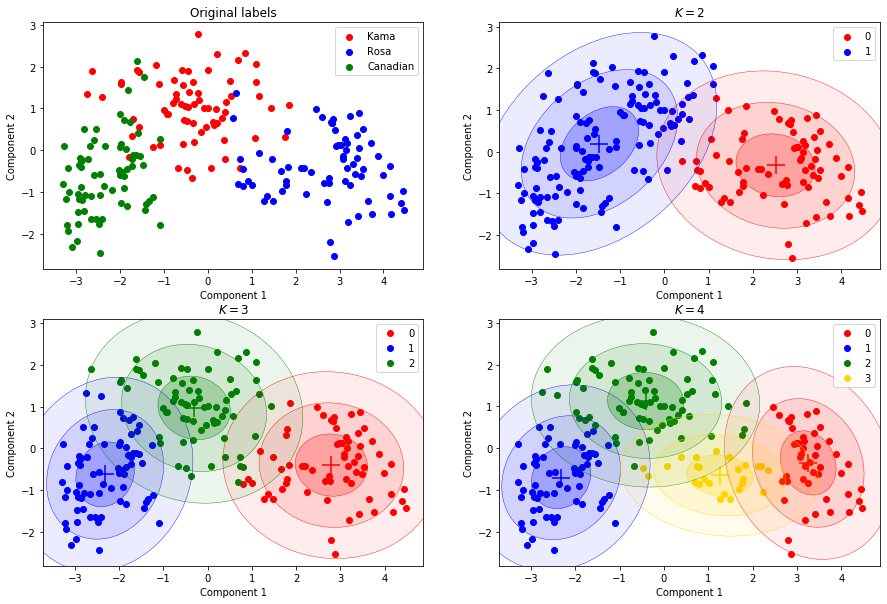

In [11]:
#per plottare i risultati ottenuti
# (ispirato a https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html)
colors = ['red', 'blue', 'green', 'gold']

def plot_results(X, Y_pred, means, covariances, ax, title):
    for i, (mean, covar, color) in enumerate(zip(means, covariances, colors)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # Plot data
        ax.scatter(X[Y_pred == i, 0], X[Y_pred == i, 1], color=color, label=i, marker='o')
        # Plot centers
        ax.scatter(mean[0], mean[1], s=300, color=color, marker='+')
        # Plot ellipses to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        color_rgba = pltcolors.to_rgba(color)
        for cov_factor in range(1, 4):
            ell = Ellipse(xy=mean, 
                          width=np.sqrt(v[0]) * cov_factor, 
                          height=np.sqrt(v[1]) * cov_factor,
                          angle=180. + angle, color=color, linewidth=.4)
            ell.set_facecolor((color_rgba[0], color_rgba[1], color_rgba[2], 1.0 / (cov_factor * 4.5)))
            ax.add_artist(ell)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend(loc='best')
    ax.set_title(title)

# Original label for data
fig, axs = plt.subplots(2, 2, figsize=(15, 10), facecolor='w', edgecolor='k')
ax = axs[0, 0]
labels = ['Kama', 'Rosa', 'Canadian']
el_per_label = 70
for i in range(3):
    ax.scatter(X_transformedPCA[i*el_per_label:(i+1)*el_per_label,0],
               X_transformedPCA[i*el_per_label:(i+1)*el_per_label,1], 
               color=colors[i],
               label=labels[i])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.legend(loc='best')
ax.set_title('Original labels')

# GMM prep k=2
ax = axs[0, 1]
plot_results(X_transformedPCA, gmm_pred[2], gmm[2].means_, gmm[2].covariances_, ax, '$K=2$')

# GMM prep k=3
ax = axs[1, 0]
plot_results(X_transformedPCA, gmm_pred[3], gmm[3].means_, gmm[3].covariances_, ax, '$K=3$')

# GMM prep k=4
ax = axs[1, 1]
plot_results(X_transformedPCA, gmm_pred[4], gmm[4].means_, gmm[4].covariances_, ax, '$K=4$')
plt.show()

L'analisi visiva è sicuramente più intuitiva rispetto ai numeri. Vediamo rappresentati quattro grafici: il primo, solo di riferimento, mostra le label originali del dataset, mentre gli altri mostrano come l'algoritmo ha strutturato i nostri dati con $K=2,3,4$.

Possiamo notare, come principale differenza tra i modelli, che il cluster $K=3$ è l'unico ad avere un numero di dati che, già ad occhio, è simile in tutti e 3 cluster creati, e le gaussiane sviluppate sono molto circolari, più che ellittiche, come invece risultano negli altri modelli (in particolare in $K=2$).

I cluster ottenuti sono buoni, in particolare quelli di $K=2,3$ erano cluster che si immaginava di ottenere già dal primo plot dei dati trasformati con PCA. Tra quelli di $K=4$, il cluster $3$ poteva essere inaspettato in prima analisi. Avendo il grafico delle label originali, vediamo che quel cluster indica in realtà un misto tra Kama e Rosa in zone lontane da dove sono principalmente concentrati i dati. Sarebbe interessante capire se questi dati possono essere considerati outliers per Kama e Rosa, ma non faremo questa analisi.

Notiamo, di nuovo precisando che non è lo scopo della nostra analisi, che i cluster ottenuti con $K=3$ si avvicinano molto alle label originali e calcolando lo stesso valore percentuale dell'analisi senza PCA otteniamo

In [12]:
#print(D[:,7],'\n',gmm_pred[3]) #commentato per leggibilità
#dal comando si vede la corrispondenza di cluster->label: 0->2, 1->3, 2->1
#mappiamo quindi i risultati
res = np.copy(gmm_pred[3])
replacements = {0: 2, 1: 3, 2: 1}
new = np.zeros(res.shape)
for idx, e in replacements.items():
    new[res == idx] = e

#calcolo del numero di elementi uguali
eq = np.where(new == D[:,7], 1., 0.)
ratio_correct = eq.sum()/eq.shape[0]
print('Ratio of cluster elements of same seed kind:',ratio_correct)

Ratio of cluster elements of same seed kind: 0.9142857142857143


La percentuale di cluster con semi dello stesso tipo è ancora molto alta e raggiunge il $91.4\%$, nonostante la semplificazione del problema tramite PCA.

Tengo a ripetere che noi non siamo a conoscenza delle label originali in un approccio unsupervised, ma la similiarità con le label classificate vuole essere un esempio di come, se applichiamo unsupervised learning su dati che non conosciamo, possiamo ottenere strutture tra i dati che ci permettono di avere delle ottime basi per fare successive analisi. Tengo a precisare anche che, con i cluster ottenuti, siamo in grado di generare nuovi dati, grazie alle gaussiane, che possiamo usare come dati artificiali per allenare algoritmi che richiedono grandi quantitativi di dati come, ad esempio, le reti neurali.

Considerazioni finali
---------------------
La semplicità e l'espressività del modello finale sono la forza delle GMM. Utilizzare un algoritmo simile al posto dell'usuale $K$-means ha poco prezzo aggiuntivo, può dare ottime indicazioni su dove muoversi nelle fasi successive e ci permette di avere un modello in grado di generare dati plausibili e, si sa, i dati non bastano mai in questo ambito.